In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/WFU Courses/DL_ML/Project 3

/content/drive/MyDrive/WFU Courses/DL_ML/Project 3


In [16]:
%reset -f

In [17]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.applications import VGG16
from keras.regularizers import l2

In [18]:
(X_train, Y_train), (X_test, Y_test) = cifar100.load_data(label_mode="fine")
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(Y_train)

OneHotEncoder(sparse=False)

In [4]:
# datagen = ImageDataGenerator(
#         featurewise_center=True,  
#         samplewise_center=False,  
#         featurewise_std_normalization=True,  
#         samplewise_std_normalization=False,   
#         rotation_range=40, 
#         width_shift_range=0.1, 
#         height_shift_range=0.1,
#         shear_range=0.2,
#         zoom_range=0.2,  
#         horizontal_flip=True,  
#         vertical_flip=False,
#         fill_mode='nearest',
#         validation_split=0.2) 

datagen = ImageDataGenerator(
          rescale=1./255,
          width_shift_range=0.2,
          zoom_range=0.2
          # height_shift_range=0.2,
          # shear_range=0.2,
          # horizontal_flip=True
          # rotation_range=20,
)
# datagen = ImageDataGenerator(
#           featurewise_center=True,
#           # featurewise_std_normalization=True,
#           rotation_range=20,
#           width_shift_range=0.2,
#           height_shift_range=0.2,
#           horizontal_flip=True
#           )

In [ ]:
print(X_train.shape)

(50000, 32, 32, 3)


In [ ]:
unique, counts = np.unique(Y_train, return_counts=True)
result = np.column_stack((unique, counts)) 
print (result)
print(len(result))

In [ ]:
n = np.random.randint(0,X_train.shape[0])
plt.imshow(X_train[n])
print(Y_train[n])

Baseline Model

In [22]:
model_baseline = Sequential()
model_baseline.add(Conv2D(32, kernel_size=(7,7), activation='relu'))
model_baseline.add(MaxPooling2D(pool_size=(2, 2)))
model_baseline.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model_baseline.add(MaxPooling2D(pool_size=(2, 2)))
model_baseline.add(Flatten())
model_baseline.add(Dense(100, activation='softmax'))

In [ ]:
model_baseline.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history_baseline = model_baseline.fit(X_train/255., one_hot_encoder.transform(Y_train), epochs=80, batch_size=128,
          validation_data=(X_test/255., one_hot_encoder.transform(Y_test)))

model_baseline.summary()

In [24]:
with open('baseline_history', 'wb') as file_pi:
        pickle.dump(history_baseline.history, file_pi)

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


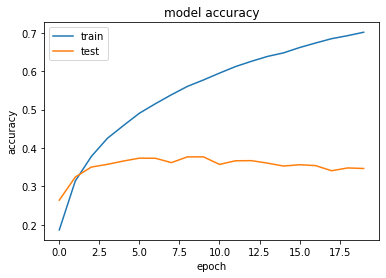

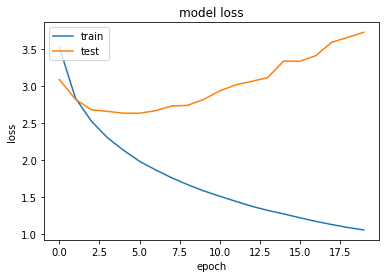

In [5]:
print(history_baseline.history.keys())
# summarize history for accuracy
plt.plot(history_baseline.history['acc'])
plt.plot(history_baseline.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('history_baseline_acc.png')
plt.show()

# summarize history for loss
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('history_baseline_loss.png')
plt.show()

In [ ]:
# from keras import models
# layer_outputs = [layer.output for layer in model_baseline.layers[:3]] 
# activation_model = models.Model(inputs=model_baseline.input, outputs=layer_outputs)
# activations = activation_model.predict(img_tensor)
# first_layer_activation = activations[0]
# second_layer_activation = activations[2]

[46]
(1, 32, 32, 3)


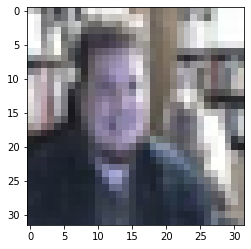

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

n = np.random.randint(0,X_train.shape[0])
plt.imshow(X_train[n])
print(Y_train[n])

img_tensor = image.img_to_array(X_train[n])
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255.
print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
layer_outputs = [layer.output for layer in model_baseline.layers[:4]] 
activation_model = models.Model(inputs=model_baseline.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1']


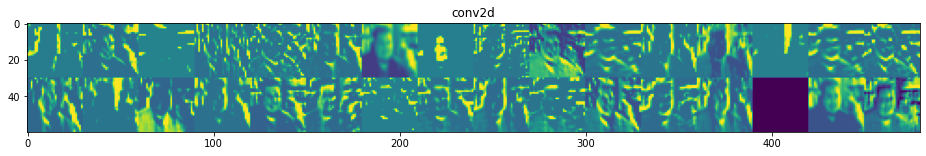

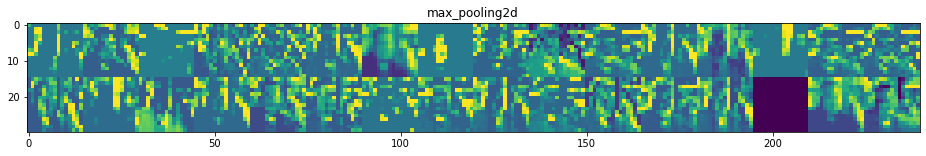

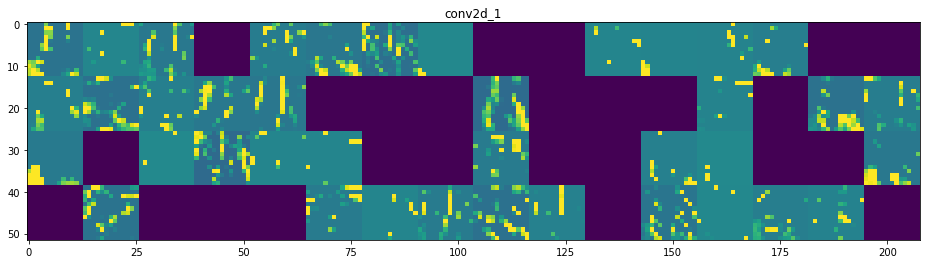

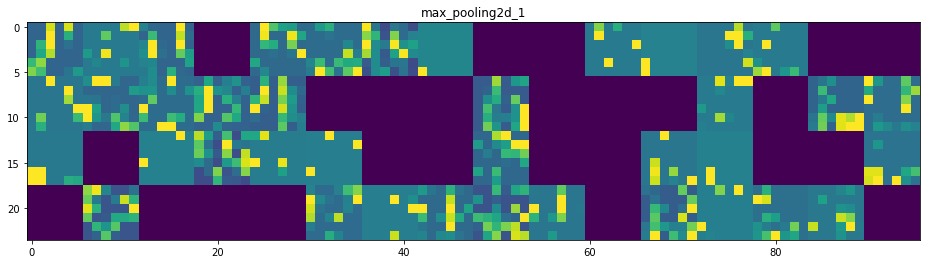

In [ ]:
layer_names = []
for layer in model_baseline.layers[:4]:
    layer_names.append(layer.name)
print(layer_names)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
      for row in range(images_per_row):
        channel_image = layer_activation[0,:, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


In [ ]:
#Second Visualization

In [ ]:
from keras import backend as K
layer_name = 'conv2d'
filter_index = 0
layer_output = model_baseline.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
# print(model_baseline.input)

In [ ]:
def generate_pattern(layer_name, filter_index, size=32):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, model.input)[0]

In [ ]:
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
grads = K.gradients(loss, model_baseline.input)[0]

In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

conv_base.trainable = False
conv_base.summary()

In [ ]:
model_T_L = Sequential()
model_T_L.add(conv_base)
model_T_L.add(Flatten())
# model_T_L.add(Dense(1024, activation='relu'))
model_T_L.add(Dense(512, activation='relu'))
model_T_L.add(Dense(100, activation='softmax'))
model_T_L.summary()

In [ ]:
# conv_base.trainable = False
batch = 128
model_T_L.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history_dev_model_vgg = model_T_L.fit(
                     datagen.flow(X_train, one_hot_encoder.transform(Y_train),
                                  batch_size=128, 
                                  seed=27,
                                  shuffle=False), 
                    #  X_train/255., one_hot_encoder.transform(Y_train),
                     epochs=50, 
                     batch_size=batch,
                     validation_data=(X_test/255., one_hot_encoder.transform(Y_test))
                    )


In [ ]:
filters, biases = model_baseline.layers[1].get_weights()

In [ ]:
model_T_L.summary() 

In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

conv_base.trainable = False
conv_base.summary()

In [32]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    # print(layer.name)
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [ ]:
model_T_L = Sequential()
model_T_L.add(conv_base)
model_T_L.add(Flatten())
# model_T_L.add(Dense(1024, activation='relu'))
model_T_L.add(Dense(512, activation='relu'))
model_T_L.add(Dense(100, activation='softmax'))
# model_T_L.summary()

In [ ]:
# conv_base.trainable = False
batch = 128
model_T_L.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history_dev_model_vgg = model_T_L.fit(
                     datagen.flow(X_train, one_hot_encoder.transform(Y_train),
                                  batch_size=128, 
                                  seed=27,
                                  shuffle=False), 
                    #  X_train/255., one_hot_encoder.transform(Y_train),
                     epochs=50, 
                     batch_size=batch,
                     validation_data=(X_test/255., one_hot_encoder.transform(Y_test))
                    )


In [ ]:
print(max(history_baseline.history['acc']))

0.5939599871635437


In [ ]:
print(history_baseline.history.keys())
# summarize history for accuracy
plt.plot(history_baseline.history['acc'])
plt.plot(history_baseline.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#========BEST MODEL SO FAR============
model_1 = Sequential()
model_1.add(Conv2D(64, kernel_size=3, activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(128, kernel_size=3, activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(256, kernel_size=3, activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# model_1.add(Conv2D(512, kernel_size=3, activation='relu'))
# model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(100, activation='softmax'))

In [ ]:
model_1 = Sequential()
model_1.add(Conv2D(128, kernel_size=3, activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(256, kernel_size=3, activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(512, kernel_size=3, activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))


# model_1.add(Conv2D(512, kernel_size=3, activation='relu'))
# model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(100, activation='softmax'))

In [ ]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history_dev_model = model_1.fit(X_train/255., one_hot_encoder.transform(Y_train), epochs=20, batch_size=64,
          validation_data=(X_test/255., one_hot_encoder.transform(Y_test)))
model_1.summary()

In [ ]:
%cd /content/drive/MyDrive/WFU Courses/DL_ML/Project 3/

/content/drive/MyDrive/WFU Courses/DL_ML/Project 3


In [ ]:
model_2 = Sequential()

model_2.add(Conv2D(128, kernel_size=3, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(MaxPooling2D(pool_size=(2, 2)))


model_2.add(Conv2D(256, kernel_size=3, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(MaxPooling2D(pool_size=(2, 2)))


model_2.add(Conv2D(512, kernel_size=3, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(MaxPooling2D(pool_size=(2, 2)))


model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(100, activation='softmax'))

In [ ]:
batch = 128
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
datagen.fit(X_train)
history_dev_model2 = model_2.fit(
                     datagen.flow(X_train, one_hot_encoder.transform(Y_train),
                                  batch_size=batch, 
                                  seed=27,
                                  shuffle=False), 
                     epochs=100, 
                     steps_per_epoch=X_train.shape[0]/batch,
                     validation_data=(X_test/255., one_hot_encoder.transform(Y_test))
                     )
model_2.summary()
filepath = '/content/drive/MyDrive/WFU Courses/DL_ML/Project 3/saved_model_1'
save_model(model_2, filepath)

In [ ]:
batch = 128
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
datagen.fit(X_train)
history_dev_model2 = model_2.fit(
                     datagen.flow(X_train, one_hot_encoder.transform(Y_train),
                                  batch_size=batch, 
                                  seed=27,
                                  shuffle=False), 
                     epochs=50, 
                     steps_per_epoch=X_train.shape[0]/batch,
                     validation_data=(X_test/255., one_hot_encoder.transform(Y_test))
                     )
model_2.summary()
filepath = '/content/drive/MyDrive/WFU Courses/DL_ML/Project 3/saved_model_1'
save_model(model_2, filepath)

In [ ]:
print(max(history_dev_model.history['acc']))

0.6267399787902832


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


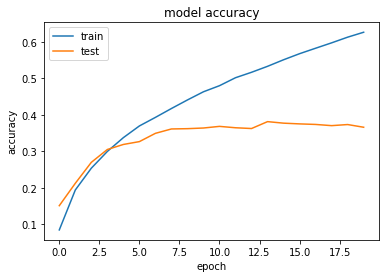

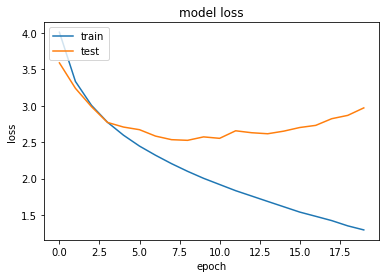

In [ ]:
print(history_dev_model.history.keys())
# summarize history for accuracy
plt.plot(history_dev_model.history['acc'])
plt.plot(history_dev_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_dev_model.history['loss'])
plt.plot(history_dev_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model_1_R = Sequential()

model_1_R.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.00001)))
model_1_R.add(Conv2D(64, kernel_size=3, activation='relu'))
model_1_R.add(MaxPooling2D(pool_size=(2, 2)))

model_1_R.add(Conv2D(256, kernel_size=(3,3), activation='relu',padding='same', kernel_regularizer=l2(0.0003)))
model_1_R.add(Conv2D(256, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.0003)))
model_1_R.add(MaxPooling2D(pool_size=(2, 2)))
model_1_R.add(Dropout(0.3))

model_1_R.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model_1_R.add(Conv2D(512, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.0005)))
model_1_R.add(MaxPooling2D(pool_size=(2, 2)))
model_1_R.add(Dropout(0.5))

model_1_R.add(Flatten())
model_1_R.add(Dense(128, activation='relu'))
model_1_R.add(Dropout(0.3))
model_1_R.add(Dense(100, activation='softmax'))

In [ ]:
batch = 256
# model_1_R.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_1_R.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['acc'])
# datagen.fit(X_train)
history_dev_model_1_R = model_1_R.fit(
                    # datagen.flow(X_train, one_hot_encoder.transform(Y_train),
                    #               batch_size=batch, 
                    #               seed=27,
                    #               shuffle=False), 
                     X_train/255., 
                     one_hot_encoder.transform(Y_train),
                     epochs=200, 
                     batch_size=batch,
#                      steps_per_epoch=X_train.shape[0]/batch,
                     validation_data=(X_test/255., one_hot_encoder.transform(Y_test))
                     )
model_1_R.summary()
with open('model_Reg_1_1_0', 'wb') as file_pi:
        pickle.dump(history_dev_model_1_R.history, file_pi)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/200
196/196 [==============================] - 36s 178ms/step - loss: 4.8555 - acc: 0.0210 - val_loss: 4.6293 - val_acc: 0.0335
Epoch 2/200
196/196 [==============================] - 34s 175ms/step - loss: 4.5889 - acc: 0.0335 - val_loss: 4.4386 - val_acc: 0.0531
Epoch 3/200
196/196 [==============================] - 34s 174ms/step - loss: 4.4166 - acc: 0.0523 - val_loss: 4.2466 - val_acc: 0.0854
Epoch 4/200
196/196 [==============================] - 34s 175ms/step - loss: 4.2596 - acc: 0.0751 - val_loss: 4.0998 - val_acc: 0.1113
Epoch 5/200
196/196 [==============================] - 35s 178ms/step - loss: 4.1216 - acc: 0.0972 - val_loss: 3.9182 - val_acc: 0.1362
Epoch 6/200
196/196 [==============================] - 34s 175ms/step - loss: 4.0137 - acc: 0.1135 - val_loss: 3.8627 - val_acc: 0.1479
Epoch 7/200
196/196 [==============================] - 34s 175ms/step - loss: 3.9206 - acc: 0.1257 - val_loss: 3.7598 - val_acc: 0.1644
Epoch 8/200
196/196 [===========================